In [25]:
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device = {device}")

device = cuda:0


# Using Tensor Equivariance to learn Covariance
The covariance of $n$ vectors, $x_i \in \mathbb{R}^d$ is an $O(d)$ equivariant function from $\mathbb{R}^{d \times n} \to \mathbb{R}^{d \times d}$.
Let's see if we can learn it.
The map we are interested in learning takes a matrix $M$ and produces $M^T \cdot M$.
We have (post)-composed that with the map $\psi : \mathbb{R}^{d\times d}$ to make this map more interesting.

In [27]:

# Number of points, n
n = 6
# Dimension, d
d = 4

# I want to make these bigger to see what happens...
#n = 8
#d = 6

N = 1_000

psi = lambda M: M + M @ M

Cov_s = []
psi_vals = []
G_s = []
outers = []
for _ in range(N): # We should generate these in a much more vectorized manner... (do you think GPT can do this?)
    # Sample points random normally:
    X = np.random.randn(d, n)
    # Covariances: these are the target:
    Cov_s.append(X @ X.T)
    # If we make a function, these would be the target:
    psi_vals.append(psi(X @ X.T))

    # This is the gram matrix (the inputs to our function):
    G_s.append(X.T @ X)
    # These are the outer products, the coefficients of our function.
    outers.append([[np.outer(X.T[i], X.T[j]) for i in range(n)] for j in range(n)])

G_s = np.array(G_s)
# Convert everything to a tensor
Cov_s = torch.tensor(Cov_s, dtype=torch.float64)
G_s = torch.tensor(np.concatenate([np.reshape(G_s, [N, n ** 2]), np.ones((N, 1))], axis=1), dtype=torch.float)
outers = torch.tensor(np.reshape(outers, [N, n ** 2, d, d]), dtype=torch.float64)
h = torch.randn(n ** 2, requires_grad=True, dtype=torch.float)

  0%|          | 0/2000 [00:00<?, ?it/s]

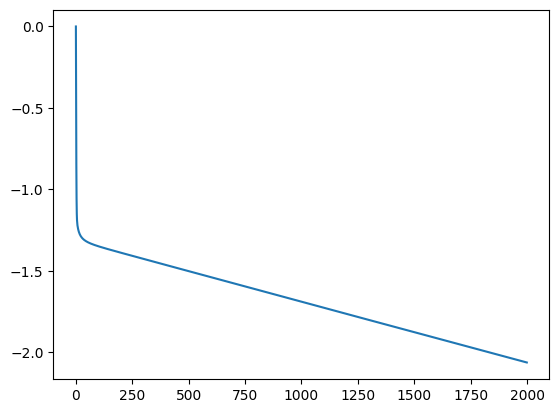

In [28]:
# Create a leaf tensor with the same shape
f_ij = torch.empty(n ** 2, n ** 2 + 1, dtype=torch.float32, device=device, requires_grad=True)

# Initialize the leaf tensor with the desired values
with torch.no_grad():
    f_ij.copy_(torch.randn(n ** 2, n ** 2 + 1, dtype=torch.float32, device=device) / ((n ** 2) * (n ** 2 + 1)))

# GPT teaching me so much
# Put everything on GPU?
f_ij = f_ij.to(device)
G_s = G_s.to(device)
outers = outers.to(device)
Cov_s = Cov_s.to(device)

# Yeah I am trying to make it work on device 


n_epochs = 2_000
# Currently, had to pick a really small learning rate for stability?!
lr = 0.0001

# Currently, not batching, will batch later:
batch_size = 1000
loss_hist = []



def F(f_ij, G_s, outers):
    f_ij_x = torch.tensordot(f_ij, G_s, dims=([1], [1])).transpose(1, 0).unsqueeze(2).unsqueeze(3)
    preds = torch.sum(f_ij_x * outers, dim=1)
    return preds

optimizer = torch.optim.SGD([f_ij], lr=lr)

for _ in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    preds = F(f_ij, G_s, outers)
    loss = torch.norm(preds - Cov_s).pow(2) / N
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())

plt.plot(np.log10(np.array(loss_hist) / loss_hist[0]))


<AxesSubplot:>

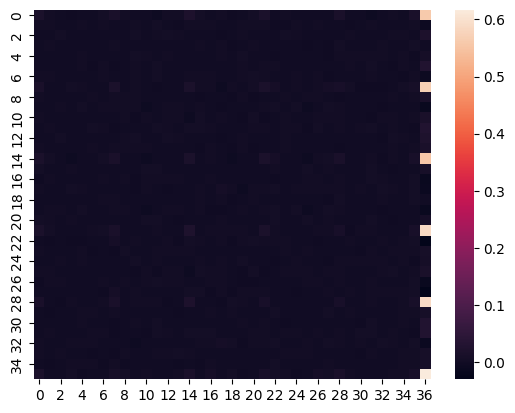

In [29]:
sns.heatmap(np.round(f_ij.cpu().data, 3))

In [30]:
f_ij.cpu().data.max()

tensor(0.6166)